In [13]:
from torch.utils import data # necessary to create a map-style dataset https://pytorch.org/docs/stable/data.html
from os.path import splitext, join
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms
import code as cu # custom utils
from typing import Optional
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
import deprecation
from torch.nn import ModuleList
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models import squeezenet1_1
from torch import nn
import torch
from torch.optim import SGD
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback, progress
from torchvision.models import squeezenet1_1
from torch import nn
import torch

dic = {
    0: 'empty',
    1: 'half',
    2: 'full'
}

# TODO: NB : ricorda che stai usando questa dimensione che è di default per evitare di riadattare la rete
# standard richiesto da squeezeNet 
data_img_size = 224

# --- funzione di utils utilizzate nel notebook conferma ---
def split_train_val_test(dataset, perc):
    train, testval = train_test_split(dataset, test_size = perc[1]+perc[2])
    val, test = train_test_split(testval, test_size = perc[2]/(perc[1]+perc[2]))
    return train, val, test

def remove_unnamed_col(df):
    res = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    return res

Verifico che il dataset sia stato adattato correttamente

In [2]:
dst_triplet_df = pd.read_csv(join('dataset', 'all_labels_triplet.csv'))

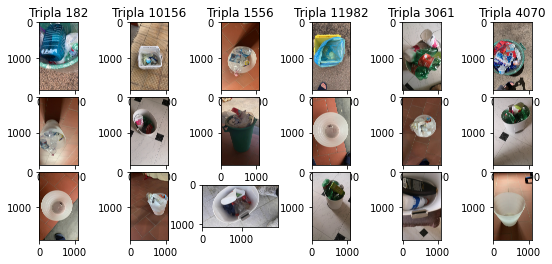

In [2]:
plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(dst_triplet_df), 6)):

    ax = plt.subplot(3,10,i+1)
    ax.set_title('Tripla {}'.format(idx))
    
    plt.subplot(3,10,i+1)
    plt.imshow(plt.imread(dst_triplet_df['anchor_image'][i]),cmap='gray')

    plt.subplot(3,10,i+11)
    plt.imshow(plt.imread(dst_triplet_df['pos_image'][i]),cmap='gray')

    plt.subplot(3,10,i+21)
    plt.imshow(plt.imread(dst_triplet_df['neg_image'][i]),cmap='gray')

plt.subplots_adjust(hspace=0.1)
plt.show()

Splitto il dataset in 3 file csv separati

In [ ]:
training_df, validation_df, test_df = split_train_val_test(dataset=dst_triplet_df, perc=[0.5, 0.2, 0.3])

training_df = remove_unnamed_col(training_df)
validation_df = remove_unnamed_col(validation_df)
test_df = remove_unnamed_col(test_df)

training_df.reset_index(drop=True, inplace=True)

validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

training_df.to_csv('dataset/triplet_training.csv')
validation_df.to_csv('dataset/triplet_validation.csv')
test_df.to_csv('dataset/triplet_test.csv')

In [14]:
class TripletTrashbinDataset(data.Dataset): # data.Dataset https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset
    def __init__(self, csv: str=None, transform: transforms=None):

        if csv is None:
            raise NotImplementedError("No default dataset is provided")
        if splitext(csv)[1] != '.csv':
            raise NotImplementedError("Only .csv files are supported")
        
        self.data = pd.read_csv(csv)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i=None):

        if i is None:
            raise NotImplementedError("Only int type is supported for get the item. None is not allowed")
        
        im_path_anchor, im_label_anchor = self.data.iloc[i]['anchor_image'], self.data.iloc[i].anchor_label
        im_anchor = Image.open(im_path_anchor)        # Handle image with Image module from Pillow https://pillow.readthedocs.io/en/stable/reference/Image.html
        if self.transform is not None:
            im_anchor = self.transform(im_anchor)

        im_path_pos, im_label_pos = self.data.iloc[i]['pos_image'], self.data.iloc[i].pos_label
        im_pos = Image.open(im_path_pos)
        if self.transform is not None:
            im_pos = self.transform(im_pos)

        im_path_neg, im_label_neg = self.data.iloc[i]['neg_image'], self.data.iloc[i].neg_label
        im_neg = Image.open(im_path_neg)
        if self.transform is not None:
            im_neg = self.transform(im_neg)

        return im_anchor, im_label_anchor, im_pos, im_label_pos, im_neg, im_label_neg

Testo che funzioni correttamente

In [3]:
dst_triplet = TripletTrashbinDataset(csv=join('dataset', 'all_labels_triplet.csv'), transform=transforms.Compose([transforms.Resize(data_img_size), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

Implemento il DataModule di pytorch lighting per utilizzarlo nel modello

In [15]:
class TripletTrashbinDataModule(pl.LightningDataModule):
    def __init__(self, img_size, batch_size=32, num_workers=0):
        super().__init__()

        self.batch_size = batch_size
        self.num_classes = 3
        self.img_size = img_size
        self.num_workers = num_workers

        self.trb_train_csv = 'dataset/triplet_training.csv'
        self.trb_val_csv = 'dataset/triplet_validation.csv'
        self.trb_test_csv = 'dataset/triplet_test.csv'

        self.transform = transforms.Compose([
                        transforms.Resize((self.img_size, self.img_size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                        # transforms.Lambda(lambda x: x.view(-1))
                    ])


    def prepare_data(self):
        # TODO: genera train e val randomicamente, al momento li tieni fissi così risparmi memoria
        print("Do nothing on prepare_data")

    def setup(self, stage: Optional[str] = None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:          
            self.trb_train = TripletTrashbinDataset(self.trb_train_csv, transform=self.transform)
            self.trb_val = TripletTrashbinDataset(self.trb_val_csv, transform=self.transform)

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.trb_test = TripletTrashbinDataset(self.trb_test_csv, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.trb_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.trb_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.trb_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [16]:
dm = TripletTrashbinDataModule(img_size=data_img_size,num_workers=0)

dm.prepare_data()
dm.setup()

Do nothing on prepare_data


In [44]:
dm.train_dataloader().dataset.data

,Unnamed: 0,anchor_image,anchor_label,pos_image,pos_label,neg_image,neg_label
0,0,dataset/images/trashbin_12974.jpg,2.0,dataset/images/trashbin_11647.jpg,2.0,dataset/images/trashbin_8807.jpg,1.0
1,1,dataset/images/trashbin_8833.jpg,1.0,dataset/images/trashbin_1721.jpg,1.0,dataset/images/trashbin_2072.jpg,2.0
2,2,dataset/images/trashbin_6310.jpg,0.0,dataset/images/trashbin_10838.jpg,0.0,dataset/images/trashbin_11344.jpg,1.0
3,3,dataset/images/trashbin_6234.jpg,0.0,dataset/images/trashbin_5107.jpg,0.0,dataset/images/trashbin_2284.jpg,2.0
4,4,dataset/images/trashbin_10748.jpg,2.0,dataset/images/trashbin_2103.jpg,2.0,dataset/images/trashbin_9974.jpg,0.0
...,...,...,...,...,...,...,...
6595,6595,dataset/images/trashbin_4840.jpg,0.0,dataset/images/trashbin_4807.jpg,0.0,dataset/images/trashbin_800.jpg,2.0
6596,6596,dataset/images/trashbin_4695.jpg,2.0,dataset/images/trashbin_3519.jpg,2.0,dataset/images/trashbin_552.jpg,1.0
6597,6597,dataset/images/trashbin_8916.jpg,1.0,dataset/images/trashbin_11205.jpg,1.0,dataset/images/trashbin_12071.jpg,0.0
6598,6598,dataset/images/trashbin_6063.jpg,0.0,dataset/images/trashbin_2653.jpg,0.0,dataset/images/trashbin_11859.jpg,2.0


/var/folders/xc/1c23sj2s5h7d869ldsyfkyk40000gn/T/ipykernel_6956/735194441.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  plt.imshow(dm.trb_train[i][0].T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wit

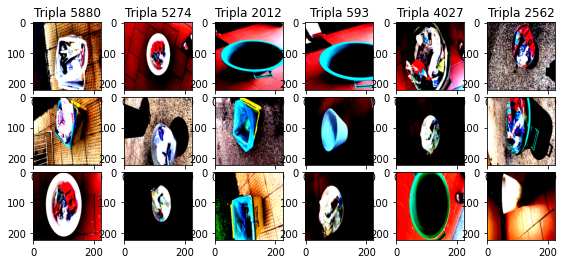

In [6]:
plt.figure(figsize=(16,4))
for i, idx in enumerate(np.random.choice(len(dm.trb_train), 6)):
    ax = plt.subplot(3,10,i+1)
    ax.set_title('Tripla {}'.format(idx))
    
    plt.imshow(dm.trb_train[i][0].T)
    plt.subplot(3,10,i+11)
    # plt.title('Class: {}'.format(dm.trb_train[i][3]))
    plt.imshow(dm.trb_train[i][2].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][4]))
    plt.subplot(3,10,i+21)
    plt.imshow(dm.trb_train[i][4].T)
    # plt.title('Class: {}'.format(dm.trb_train[i][5]))

plt.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
# TODO: auto-batch-size

# trainer = pl.Trainer(auto_scale_batch_size="power", max_epochs=-1)
# model = TripletNetworkTask(embedding_net=base_model)
# trainer.tune(model, train_dataloaders=trb_train_loader, val_dataloaders=trb_val_loader)


# TODO: auto-lr

Che input vuole il modello

In [17]:
class TripletNetworkTask(pl.LightningModule):
    # lr uguale a quello del progetto vecchio
    def __init__(self, embedding_net, lr=0.002, momentum=0.99, margin=2, num_class=3):
        super(TripletNetworkTask, self).__init__()

        # TODO: credo debba essere escluso https://pytorch-lightning.readthedocs.io/en/latest/common/hyperparameters.html
        # self.save_hyperparameters()
        self.save_hyperparameters(ignore=['embedding_net'])
        self.embedding_net = embedding_net
        self.criterion = nn.TripletMarginLoss(margin=margin)
        self.num_class = num_class
        self.lr = lr
        self.momentum = momentum
        self.batch_size = 32

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # TODO: abilita uno o l'altro in base a se abiliti save_hyparameters()
        # self.hparams --> è quella di embedding_net
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)

    # Lightning automatically sets the model to training for training_step and to eval for validation.
    def training_step(self, batch, batch_idx):
        I_i, I_j, I_k, *_ = batch

        anchor = self.embedding_net(I_i)
        positive = self.embedding_net(I_j)
        negative = self.embedding_net(I_k)

        # calcolo la loss
        l = self.criterion(anchor, positive, negative)

        #TripletMargin Loss

        # TODO: Triplet Maring with distance loss con funzione custom,
        # magari prova con una custom ?
        # tmwdl_loss = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance())
        # tmwdl_output = tmwdl_loss(anchor, positive, negative)

        # TODO: prova al contrario
        self.log('train/tripletMargin', l)
        # self.log('train/tripletMarginWithDinstance', tmwdl_output)

        return l

    def validation_step(self, batch, batch_idx):
        I_i, I_j, I_k, *_ = batch
        anchor = self.embedding_net(I_i)
        positive = self.embedding_net(I_j)
        negative = self.embedding_net(I_k)
        
        l = self.criterion(anchor, positive, negative)
        
        #TripletMargin Loss

        # TODO: prova al contrario
        self.log('valid/tripletMargin', l)
        
        if batch_idx == 0:
            self.logger.experiment.add_embedding(anchor, batch[3], I_i, global_step=self.global_step)

In [20]:
triplet_embeddingNet = TripletNetworkTask(embedding_net)
logger = TensorBoardLogger("metric_logs", name="triplet_embeddingNet")

trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

trainer.fit(model=triplet_embeddingNet, datamodule=dm)

# trainer.fit(model=triplet_squeezenet1_1, train_dataloaders=trb_train_loader, val_dataloaders=trb_val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | EmbeddingNet      | 351 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.406     Total estimated model params size (MB)


Do nothing on prepare_data


Sanity Checking: 0it [00:00, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32]

Test con dataloader pytorch

In [28]:
trb_train_csv = 'dataset/triplet_training.csv'
trb_val_csv = 'dataset/triplet_validation.csv'
trb_test_csv = 'dataset/triplet_test.csv'

trnf = transforms.Compose([transforms.Resize(data_img_size), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trb_train = TripletTrashbinDataset(trb_train_csv, transform=trnf)
trb_val = TripletTrashbinDataset(trb_val_csv, transform=trnf)

trb_train_loader = DataLoader(trb_train, batch_size=32, shuffle=True, num_workers=0)
trb_val_loader = DataLoader(trb_val, batch_size=32, num_workers=0)

Test con dataModule

In [ ]:
squezenet_fe = squeezenet1_1(pretrained=True)

# rimuovo classificatore finale, imposto il modulo identità al posto del classificatore
squezenet_fe.classifier = nn.Identity()

print("Dimensione del vettore di feature estratto per immagine {} -> {}".format(torch.zeros(1,3,data_img_size,data_img_size).shape, squezenet_fe(torch.zeros(1,3,data_img_size,data_img_size)).shape))

triplet_squeezenet1_1 = TripletNetworkTask(squezenet_fe)
logger = TensorBoardLogger("metric_logs", name="siamese_squeezenet1_1")

trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

trainer.fit(model=triplet_squeezenet1_1, datamodule=dm)

# trainer.fit(model=triplet_squeezenet1_1, train_dataloaders=trb_train_loader, val_dataloaders=trb_val_loader)

In [49]:
from torchvision.models import mobilenet_v2
mobileNet_v2 = mobilenet_v2()

mobileNet_v2.classifier = nn.Identity()

print("required for mobilenet_v2: {}".format( mobileNet_v2(torch.zeros(1,3,224,224)).shape))

triplet_mobileNet = TripletNetworkTask(mobileNet_v2)
logger = TensorBoardLogger("metric_logs", name="siamese_mobilenet_v1")

trainer = pl.Trainer(gpus=0,
                    max_epochs=1,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

# trainer.fit(model=triplet_mobileNet, datamodule=dm)

trainer.fit(model=triplet_mobileNet, train_dataloaders=trb_train_loader, val_dataloaders=trb_val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | MobileNetV2       | 2.2 M 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.895     Total estimated model params size (MB)


required for mobilenet_v2: torch.Size([1, 1280])


Sanity Checking: 0it [00:00, ?it/s]

/Users/danilo/GitHub/deep-learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: stack expects each tensor to be equal size, but got [3, 398, 224] at entry 0 and [3, 224, 398] at entry 6

In [ ]:
dm.train_dataloader()